In [1]:
import os
root_dir = 'D:\LAB\DATA'

In [2]:
# !pip install segmentation-models-pytorch
# !pip install ipywidgets

Import Libraries

In [3]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch.nn import ModuleList

import random
import os, shutil
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# import segmentation_models_pytorch as smp

%matplotlib inline

Setup config class

In [4]:
class Config:
    
    data_dir = os.path.join(root_dir, "kaggle_3m/")
    
    validation_fraction = 0.15
    test_fraction = 0.10
    train_batch = 16
    valid_batch = 32
    test_batch = 32
    
    input_dim = 256
    input_ch = 3
    output_dim = 256
    output_ch = 1

    INPUT_IMAGE_HEIGHT=256
    

    seed = 1
    learning_rate = 0.01
    epochs = 30
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Helper Functions

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def plot_example(idx):
    base_path = Config.data_dir+ test_df['directory'].iloc[idx]
    img_path = os.path.join(base_path, test_df['images'].iloc[idx])
    mask_path = os.path.join(base_path, test_df['masks'].iloc[idx])
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].imshow(img)
    ax[0].set_title("Image")
    ax[1].imshow(mask)
    ax[1].set_title("Mask")
    plt.show()

In [6]:
def show_sample(sample, title=None):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(sample[0])
    ax[1].imshow(sample[1], cmap="gray")
    if title:
        fig.suptitle(title)
    plt.show()

In [7]:
def plot_predictions(model, idx):
    base_path = os.path.join(Config.data_dir, test_df['directory'].iloc[idx])
    img_path = os.path.join(base_path, test_df['images'].iloc[idx])
    mask_path = os.path.join(base_path, test_df['masks'].iloc[idx])
    
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    
    tensor_img, tensor_mask = eval_transforms((img, mask))
    tensor_img = tensor_img.unsqueeze(0).to(Config.device)
    
    model.eval()
    
    with torch.no_grad():
        pred = model(tensor_img)[0].detach().cpu().numpy()
        pred = pred.transpose((1,2,0)).squeeze()
        rounded = np.round(pred)
        
    plot_images = {
        'Image': img,
        'Mask': mask,
        'Predicted Mask': pred,
        'Predicted Rounded Mask':rounded
    }
    
    fig, ax = plt.subplots(1, 4, figsize=(16,4))
    for i, key in enumerate(plot_images.keys()):
        ax[i].imshow(plot_images[key])
        ax[i].set_title(key)
        
    plt.show()
        
        

In [8]:
set_seed(Config.seed)

Preparing Data

In [9]:
dirs, images, masks = [], [], []

i =0

for root, folders, files in  os.walk(Config.data_dir):
    for file in files:
        if 'mask' in file:
            dirs.append(root.replace(Config.data_dir, ''))
            masks.append(file)
            images.append(file.replace("_mask", ""))

PathDF = pd.DataFrame({'directory': dirs,
                      'images': images,
                      'masks': masks})
PathDF.head()

,directory,images,masks
0,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_10.tif,TCGA_CS_4941_19960909_10_mask.tif
1,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_11.tif,TCGA_CS_4941_19960909_11_mask.tif
2,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_12.tif,TCGA_CS_4941_19960909_12_mask.tif
3,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_13.tif,TCGA_CS_4941_19960909_13_mask.tif
4,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_14.tif,TCGA_CS_4941_19960909_14_mask.tif


In [10]:
for i in PathDF.index:
    PathDF.loc[i, "diagnosis"] = 1 if np.max(cv2.imread(os.path.join(Config.data_dir, PathDF.loc[i, 'directory'], PathDF.loc[i,"masks"]))) > 0 else 0

In [11]:
PathDF.head()

,directory,images,masks,diagnosis
0,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_10.tif,TCGA_CS_4941_19960909_10_mask.tif,0.0
1,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_11.tif,TCGA_CS_4941_19960909_11_mask.tif,1.0
2,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_12.tif,TCGA_CS_4941_19960909_12_mask.tif,1.0
3,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_13.tif,TCGA_CS_4941_19960909_13_mask.tif,1.0
4,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_14.tif,TCGA_CS_4941_19960909_14_mask.tif,1.0


In [12]:
PathDF['diagnosis'].value_counts()

0.0    2556
1.0    1373
Name: diagnosis, dtype: int64

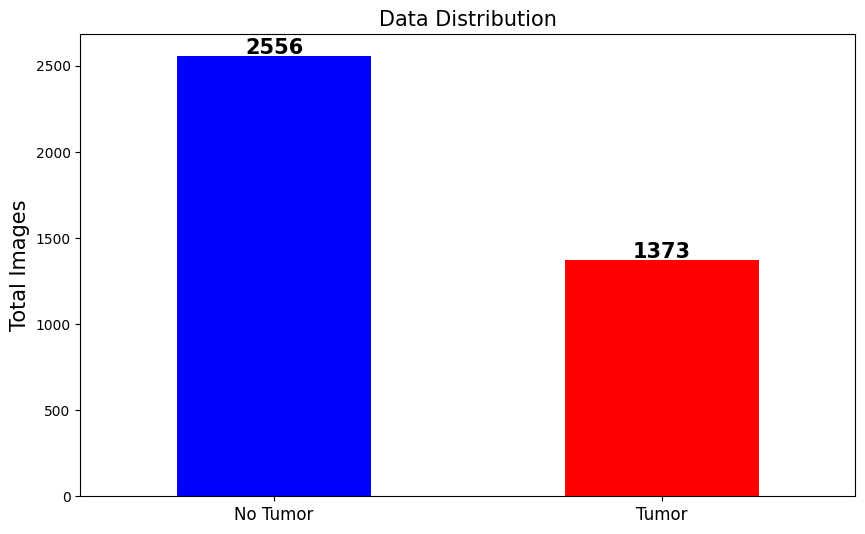

In [13]:
ax = PathDF['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(PathDF['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

Train, Val, Test Split

In [14]:
train2rest = Config.validation_fraction + Config.test_fraction
test2valid = Config.validation_fraction / train2rest

train_df, rest = train_test_split(PathDF, random_state=Config.seed,
                                 test_size = train2rest)

test_df, valid_df = train_test_split(rest, random_state=Config.seed,
                                    test_size = test2valid)

print('Train:', train_df.shape[0])
print('Valid:', valid_df.shape[0])
print('Test:', test_df.shape[0])

Train: 2946
Valid: 590
Test: 393


Visualization of images and masks

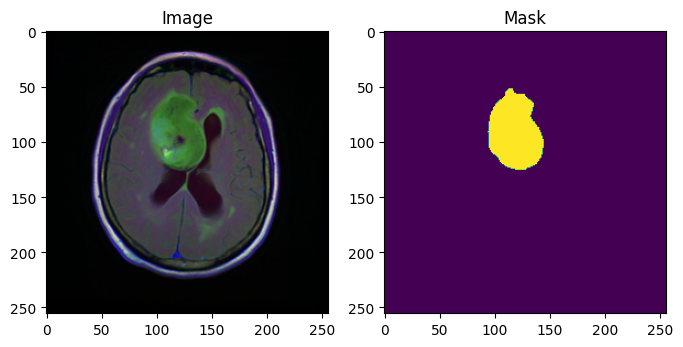

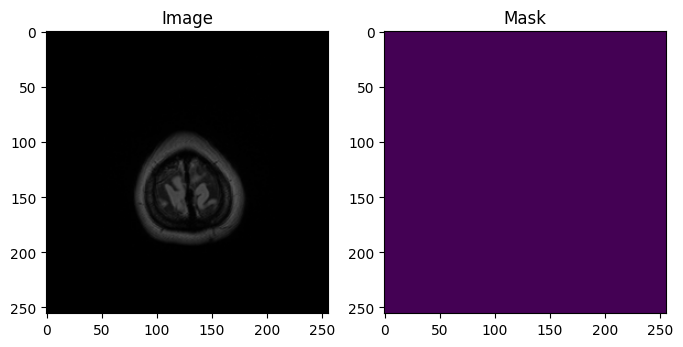

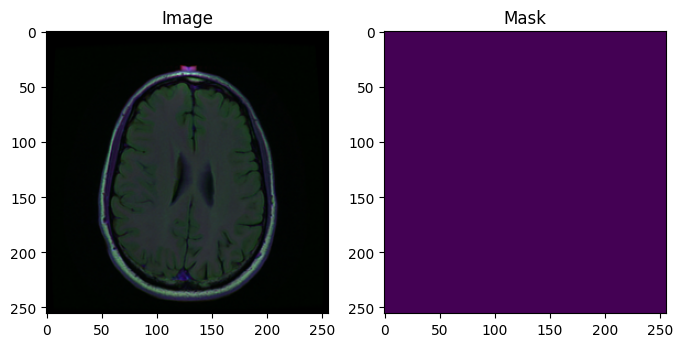

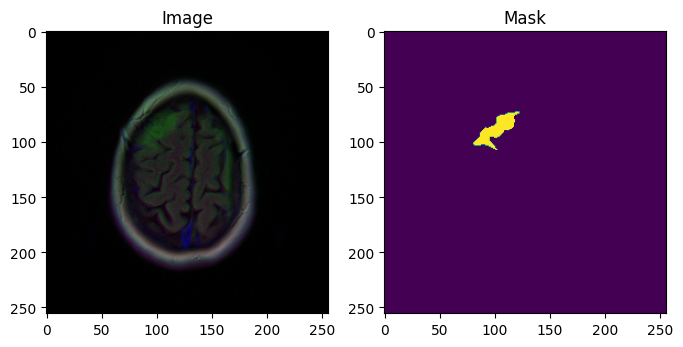

In [15]:
plot_example(0)
plot_example(5)
plot_example(10)
plot_example(20)

Dataset Class

In [16]:
class MRI_Dataset(Dataset):
    def __init__(self, path_df, transform=None):
        self.path_df = path_df
        self.transform = transform
        
    def __len__(self):
        return self.path_df.shape[0]
    
    def __getitem__(self, idx):
        
        base_path = os.path.join(Config.data_dir, self.path_df.iloc[idx]['directory'])
        img_path = os.path.join(base_path, self.path_df.iloc[idx]['images'])
        mask_path = os.path.join(base_path, self.path_df.iloc[idx]['masks'])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        sample = (image, mask)
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample        

Custom Transformations

In [17]:
class PairedRandomHorizontalFlip():
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, sample):
        img, mask = sample
        if np.random.random() < self.p:
            img, mask = TF.hflip(img), TF.hflip(mask)
            
        return img, mask

In [18]:
class PairedRandomAffine():
    def __init__(self, degrees= None, translate=None, scale_ranges=None,
                shears=None):
        self.params = {
            'degree': degrees,
            'translate': translate,
            'scale_ranges':scale_ranges,
            'shears':shears
        }
    def __call__(self, sample):
        img, mask = sample
        w, h = img.size
        
        angle, translations, scale, shear = transforms.RandomAffine.get_params(
            self.params['degree'], self.params['translate'],
            self.params['scale_ranges'], self.params['shears'],
            (w,h)
        )
        
        img = TF.affine(img, angle, translations, scale, shear)
        mask = TF.affine(mask, angle, translations, scale, shear)
        
        return img, mask

In [19]:
class PairedToTensor():
    def __call__(self, sample):
        img, mask = sample
        img = np.array(img)
        mask = np.expand_dims(mask, -1)
        img = np.moveaxis(img, -1, 0)
        mask = np.moveaxis(mask, -1, 0)
        img, mask = torch.FloatTensor(img), torch.FloatTensor(mask)
        img = img/255
        mask = mask/255
        return img, mask

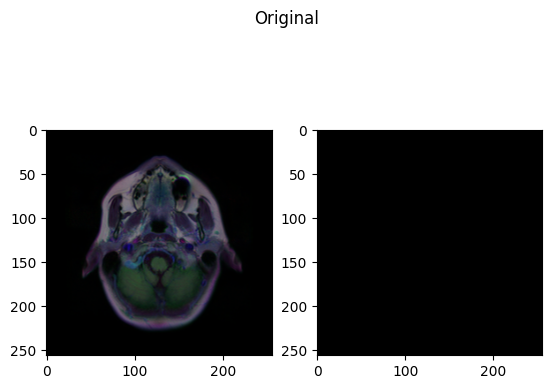

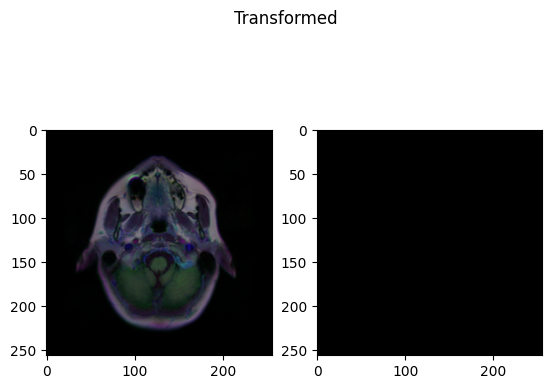

In [20]:
dataset = MRI_Dataset(test_df)
sample = dataset[59]
transform = PairedRandomHorizontalFlip(p=1)
show_sample(sample, title='Original')
show_sample(transform(sample), title="Transformed")

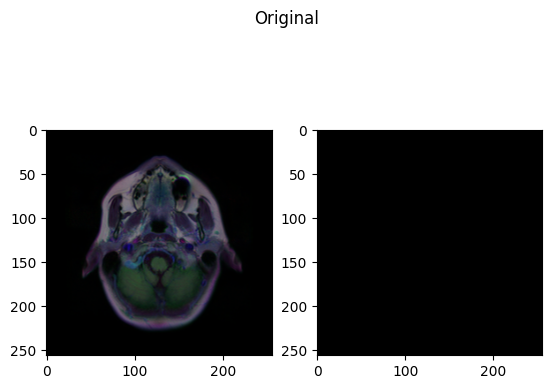

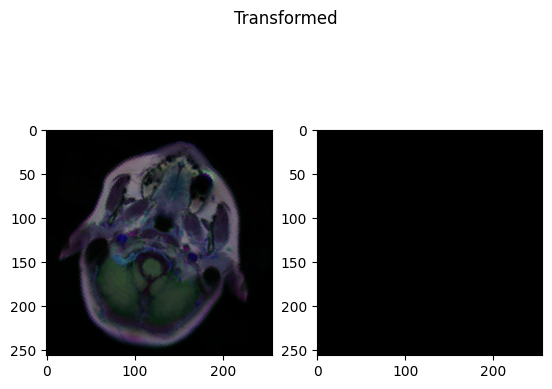

In [21]:
transform = PairedRandomAffine(
    degrees = (15,15),
    scale_ranges = (1.2, 1.2)
)
show_sample(sample, "Original")
show_sample(transform(sample), 'Transformed')

Data transformations and loaders

In [22]:
Resize = transforms.Resize((128, 128))
train_transforms = transforms.Compose(
    [PairedRandomHorizontalFlip(),
    PairedRandomAffine(
        Resize,
        degrees=(-15, 15),
        translate=(0.1, 0.1),
        scale_ranges=(0.8, 1.2)
    ),
    PairedToTensor()
    ])

eval_transforms = PairedToTensor()

train_data = MRI_Dataset(train_df, transform=train_transforms)
valid_data = MRI_Dataset(valid_df, transform=eval_transforms)
test_data = MRI_Dataset(test_df, transform=eval_transforms)

train_loader = DataLoader(train_data, batch_size=Config.train_batch,
                         shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_data, batch_size=Config.valid_batch,
                         shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=Config.test_batch,
                        shuffle=False, num_workers=0)

Defining the Model

In [106]:
class Block(nn.Module): 
	def __init__(self, input_ch, output_ch): 
		super().__init__() 
		# store the convolution and RELU layers
		self.conv1 = nn.Conv2d(input_ch, output_ch, 3) 
		self.relu = nn.ReLU() 
		self.conv2 = nn.Conv2d(output_ch, output_ch, 3) 
 
	def forward(self, x): 

		# apply CONV => RELU => CONV block to the inputs and return it
		output = self.conv1(x)
		output = self.relu(output)
		output = self.conv2(output)
		return output

In [107]:
class Encoder(nn.Module): 
	def __init__(self, channels=(3, 16, 32, 64)): 
		super().__init__() 
		# store the encoder blocks and maxpooling layer 
		self.encBlocks = ModuleList( 
			[Block(channels[i], channels[i + 1]) 
			 	for i in range(len(channels) - 1)]) 
		self.pool = nn.MaxPool2d(2) 
 
	def forward(self, x): 
		# initialize an empty list to store the intermediate outputs 
		blockOutputs = [] 
 
		# loop through the encoder blocks 
		for block in self.encBlocks: 
			# pass the inputs through the current encoder block, store 
			# the outputs, and then apply maxpooling on the output 
			x = block(x) 
			blockOutputs.append(x) 
			x = self.pool(x) 
 
		# return the list containing the intermediate outputs 
		return blockOutputs

In [108]:
class Decoder(nn.Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and 
		# decoder blocks 
		self.channels = channels 
		self.upconvs = ModuleList( 
			[nn.ConvTranspose2d(channels[i], channels[i + 1], 2, 2) 
			 	for i in range(len(channels) - 1)]) 
		self.dec_blocks = ModuleList( 
			[Block(channels[i], channels[i + 1]) 
			 	for i in range(len(channels) - 1)]) 

	def forward(self, x, encFeatures):
		# loop through the number of channels 
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks 
			x = self.upconvs[i](x)
			
			# crop the current features from the encoder blocks, 
			# concatenate them with the current upsampled features, 
			# and pass the concatenated output through the current 
			# decoder block 
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1) 			
			x = self.dec_blocks[i](x) 
 
		# return the final decoder output 
		return x 
 
	def crop(self, encFeatures, x): 
		# grab the dimensions of the inputs, and crop the encoder 
		# features to match the dimensions 
		(_, _, H, W) = x.shape 
		encFeatures = transforms.CenterCrop([H, W])(encFeatures) 
 
		# return the cropped features 
		return encFeatures

In [109]:
class UNet(nn.Module):
    def __init__(self, encChannels=(3, 16, 32, 64), decChannels=(64, 32, 16),
                 nbClasses=1, retainDim=True,
                 outSize=(128, 128)):
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)

        # initialize the regression head and store the class variables
        self.head = nn.Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize

    def forward(self, x):
		# grab the features from the encoder
        encFeatures = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])

		# pass the decoder features through the regression head to
		# obtain the segmentation mask
        map = self.head(decFeatures)

		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)

		# return the segmentation map
        return map	

In [102]:
encChannels=(3, 16, 32, 64)
model = Encoder(encChannels)
get = model(t)

# get = get[:-1]

print('==', get[0].shape)
print('==', get[1].shape)
print('==', get[2].shape)

01 3 16
02 torch.Size([4, 3, 128, 128])
03 torch.Size([4, 16, 126, 126])
04 torch.Size([4, 16, 126, 126])
05 torch.Size([4, 16, 124, 124])
01 16 32
02 torch.Size([4, 16, 62, 62])
03 torch.Size([4, 32, 60, 60])
04 torch.Size([4, 32, 60, 60])
05 torch.Size([4, 32, 58, 58])
01 32 64
02 torch.Size([4, 32, 29, 29])
03 torch.Size([4, 64, 27, 27])
04 torch.Size([4, 64, 27, 27])
05 torch.Size([4, 64, 25, 25])
== torch.Size([4, 16, 124, 124])
== torch.Size([4, 32, 58, 58])
== torch.Size([4, 64, 25, 25])


In [110]:
model = UNet(encChannels = ())

In [111]:
t = torch.randn((4, 3, 128, 128))
print(t.shape)
get = model(t)
print(get.shape)
# print(get[1].shape)
# print(get[2].shape)

torch.Size([4, 3, 128, 128])
torch.Size([4, 1, 128, 128])


In [28]:
# import torch
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#     in_channels=3, out_channels=1, init_features=32, pretrained=True)

# model = smp.Unet(    
#     in_channels=Config.input_ch,                  
#     classes=Config.output_ch,
#     activation="sigmoid").to(Config.device)


Loss and metrics

In [29]:
# # code taken from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduction=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction:
            return torch.mean(F_loss)
        else:
            return F_loss

In [30]:
# code taken from https://www.kaggle.com/code/lqdisme/brain-mri-segmentation-unet-pytorch/notebook

def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1
    return intersection / union


Training Loop

In [31]:
def train_loop(model, optimizer, criterion, train_loader,
              device=Config.device):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')
    
    final_dice_coef = 0 
    
    for imgs, masks in pbar:
        # pass to device
        imgs = imgs.to(device)
        masks = masks.to(device)
        # forward
        out = model(imgs)
        loss = criterion(out, masks)
        running_loss += loss.item() * imgs.shape[0]
#         print(loss.item())
        
        out_cut = np.copy(out.detach().cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
        train_dice = dice_coef_metric(out_cut, masks.data.cpu().numpy())
        final_dice_coef += train_dice 
        
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    running_loss /= len(train_loader.sampler)
    return {'dice coef':final_dice_coef/len(train_loader), 
                'loss':running_loss}

Evaluation Loop

In [32]:
def eval_loop(model, criterion, eval_loader, device=Config.device):
    
    running_loss = 0
    final_dice_coef = 0 
    
    model.eval()
    with torch.no_grad():

        pbar = tqdm(eval_loader, desc='Interating over evaluation data')
        
        for imgs, masks in pbar:
            
            imgs = imgs.to(device)
            masks = masks.to(device)
            
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item() * imgs.shape[0]
            print(loss.item())
            
            out_cut = np.copy(out.detach().cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            valid_dice = dice_coef_metric(out_cut, masks.data.cpu().numpy())
            final_dice_coef += valid_dice 
            
    running_loss /= len(eval_loader.sampler)   
    return {
                'dice coef':final_dice_coef/len(eval_loader), 
                'loss':running_loss}

In [33]:
def train(model, optimizer, criterion, scheduler, train_loader, 
          valid_loader,device = Config.device,
          num_epochs = Config.epochs,
          valid_loss_min = np.inf):
    
    train_loss_list = []
    train_dice_coef = []
    val_loss_list = []
    val_dice_coef = []

    for e in range(num_epochs):
        
        train_metrics = train_loop(model, optimizer, criterion, 
                                   train_loader, device=device)
        
        val_metrics = eval_loop(model, criterion, valid_loader, device=device)
        
        scheduler.step(val_metrics['dice coef'])
        
        train_loss_list.append(train_metrics['loss']) 
        train_dice_coef.append(train_metrics['dice coef'])
        val_loss_list.append(val_metrics['loss'])
        val_dice_coef.append(val_metrics['dice coef'])
        
        print_string = f"Epoch: {e+1}\n"
        print_string += f"Train Loss: {train_metrics['loss']:.5f}\n"
        print_string += f"Train Dice Coef: {train_metrics['dice coef']:.5f}\n"
        print_string += f"Valid Loss: {val_metrics['loss']:.5f}\n"
        print_string += f"Valid Dice Coef: {val_metrics['dice coef']:.5f}\n"
        print(print_string)
        
        # save model
        if val_metrics["loss"] <= valid_loss_min:
            torch.save(model.state_dict(), "UNET.pt")
            valid_loss_min = val_metrics["loss"]
    return [train_loss_list,
    train_dice_coef,
    val_loss_list,
    val_dice_coef]

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
criterion = nn.BCELoss(reduction='mean')
train_loss_list, train_dice_coef,val_loss_list,val_dice_coef = train(
    model, optimizer, criterion, scheduler, train_loader, valid_loader)

In [ ]:
plt.plot(np.arange(1, Config.epochs + 1), train_loss_list, label="train loss")
plt.plot(np.arange(1, Config.epochs + 1), val_loss_list, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and validation loss")
plt.show()

In [ ]:
plt.plot(np.arange(1, Config.epochs + 1), train_dice_coef, label="train dice score")
plt.plot(np.arange(1, Config.epochs + 1), val_dice_coef, label="val dice score")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.legend()
plt.title("Training and validation Dice Score")
plt.show()

In [ ]:
plot_predictions(model, 59)
plot_predictions(model, 0)
plot_predictions(model, 26)
plot_predictions(model, 3)

In [ ]:
plot_predictions(model, 7)
plot_predictions(model, 31)
plot_predictions(model, 28)
plot_predictions(model, 1)

In [ ]:
plot_predictions(model, 15)
plot_predictions(model, 19)
plot_predictions(model, 25)
plot_predictions(model, 73)

Heavily Inspired from https://www.kaggle.com/code/anastasiiaselezen/brain-mri-segmentation-pytorch